In [1]:
import os
import sys
print(os.getcwd())
sys.path.append("../WanPy")

from WanPy import *
from pythtb import *
from pythTB_wan import Bloch, K_mesh, Wannier
import models
import plotting as plot

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

sv_dir = 'data'
if not os.path.exists(sv_dir):
    os.makedirs(sv_dir)

/Users/treycole/Codes/WanPy/top_obstruction


In [7]:
# tight-binding parameters
delta = 1

# # checkerboard
# t0 = 0.4
# tprime = 0.5

# Haldane
t = 1
t2 = -0.4

n_super_cell = 2
model = models.Haldane(delta, t, t2).make_supercell([[n_super_cell, 0], [0, n_super_cell]])
# model = models.chessboard(t0, tprime, delta).make_supercell([[n_super_cell, 0], [0, n_super_cell]])
# model.display()

In [8]:
low_E_sites = np.arange(0, model.get_num_orbitals(), 2)
high_E_sites = np.arange(1, model.get_num_orbitals(), 2)
lat_vecs = model.get_lat()
orb_vecs = model.get_orb()

n_orb = model.get_num_orbitals()
n_occ = int(n_orb/2)

u_wfs_full = wf_array(model, [20, 20])
u_wfs_full.solve_on_grid([0, 0])
chern = u_wfs_full.berry_flux([i for i in range(n_occ)])/(2*np.pi)

model_str = f'C={chern:.1f}_Delta={delta}_t={t}_t2={t2}'

print(f"Low energy sites: {low_E_sites}")
print(f"High energy sites: {high_E_sites}")
print(f"Chern # occupied: {chern: .1f}")

Low energy sites: [0 2 4 6]
High energy sites: [1 3 5 7]
Chern # occupied:  1.0


In [9]:
# only one should be true
random = False
low_E = False
omit = True

if random:
    omit_num = 2
    n_tfs = n_occ - omit_num
    tf_list = ["random", n_tfs]
elif omit:
    omit_sites = 2
    tf_list = list(np.setdiff1d(low_E_sites, [omit_sites])) # delta on lower energy sites omitting the last site
    # np.random.choice(low_E_sites, n_tfs, replace=False)
    n_tfs = len(tf_list)
elif low_E:
    tf_list = list(low_E_sites)
    n_tfs = len(tf_list)

Wan_frac = n_tfs/n_occ

if random:
    save_sfx = model_str + f'_tfxs={tf_list}'
else:
    save_sfx = model_str + f'_tfx={np.array(tf_list, dtype=int)}'

print(f"Trial wavefunctions: {tf_list}")
print(f"# of Wannier functions: {n_tfs}")
print(f"# of occupied bands: {n_occ}")
print(f"Wannier fraction: {Wan_frac}")
print(save_sfx)

Trial wavefunctions: [np.int64(0), np.int64(4), np.int64(6)]
# of Wannier functions: 3
# of occupied bands: 4
Wannier fraction: 0.75
C=1.0_Delta=1_t=1_t2=-0.4_tfx=[0 4 6]


In [10]:
nks = 20, 20
WF = Wannier(model, nks)
loc_steps = {}

In [11]:
WF.single_shot(tf_list)
WF.report()
loc_steps["P"] = {"Omega": WF.spread, "Omega_i": WF.omega_i, "Omega_til": WF.omega_til, "centers": WF.get_centers()}

Wannier function report
 --------------------- 
Quadratic spreads:
w_0 --> 0.27158
w_1 --> 0.27158
w_2 --> 0.27158
Centers:
w_0 --> [0.16514 0.16743]
w_1 --> [0.66743 0.16743]
w_2 --> [0.66743 0.66514]
Omega_i = 0.7388768356161961
Omega_tilde = 0.07587061897670629


In [14]:
iter_num = 100000

WF.max_loc(eps=5e-2, iter_num=iter_num, tol=1e-12, grad_min=1e-10, verbose=True)

loc_steps["P+ML"] = {
    "Omega": WF.spread, "Omega_i": WF.omega_i, "Omega_til": WF.omega_til,
    "centers": WF.get_centers(), "iter_num": iter_num}

WF.report()

0 Omega_til = 0.07285947001337524, Grad mag: 24.861012944078517
1 Omega_til = 0.07271399555661595, Grad mag: 17.564911716933395
2 Omega_til = 0.0726009875082984, Grad mag: 17.331694415192416
3 Omega_til = 0.07251022639807118, Grad mag: 17.101628910890067
4 Omega_til = 0.07243525430257379, Grad mag: 16.874672641067
5 Omega_til = 0.07237182041692664, Grad mag: 16.650781607663607
6 Omega_til = 0.07231703441247046, Grad mag: 16.429911612055456
7 Omega_til = 0.07226887770036057, Grad mag: 16.212018833171136
8 Omega_til = 0.07222590811253664, Grad mag: 15.99706009674524
9 Omega_til = 0.07218707473564698, Grad mag: 15.78499299326377
10 Omega_til = 0.07215159820274135, Grad mag: 15.575775919928747
11 Omega_til = 0.07211889127765479, Grad mag: 15.36936808416285
12 Omega_til = 0.0720885049863661, Grad mag: 15.165729487937528
13 Omega_til = 0.07206009136549985, Grad mag: 14.964820903058639
14 Omega_til = 0.07203337725815323, Grad mag: 14.766603842800224
15 Omega_til = 0.07200814559897928, Grad ma

In [15]:
nks = 20, 20
WF = Wannier(model, nks)

# initial projection
WF.single_shot(tf_list)

# subspace selection
iter_num = 100000
WF.subspace_selec(iter_num=iter_num, tol=1e-12, verbose=True)

# second projection
psi_til_til = WF.get_psi_tilde(
        WF.tilde_states._psi_wfs, WF.trial_wfs, 
        state_idx=list(range(WF.tilde_states._psi_wfs.shape[2]))
        )
WF.set_tilde_states(psi_til_til, cell_periodic=False)

loc_steps["P+SS+P"] = {
    "Omega": WF.spread, "Omega_i": WF.omega_i, "Omega_til": WF.omega_til,
    "centers": WF.get_centers(), "iter_num": iter_num}

# max-loc
iter_num = 100000
WF.max_loc(eps=5e-2, iter_num=iter_num, tol=1e-12, grad_min=1e-10, verbose=True)

loc_steps["P+SS+P+ML"] = {
    "Omega": WF.spread, "Omega_i": WF.omega_i, "Omega_til": WF.omega_til,
    "centers": WF.get_centers(), "iter_num": iter_num}


sv_prefix = 'WF_loc_steps'
file_name = f"{sv_dir}/{sv_prefix}_{save_sfx}"
np.save(file_name, loc_steps)

sv_prefix = 'WF_max_loc'
file_name = f"{sv_dir}/{sv_prefix}_{save_sfx}"
np.save(file_name, WF)

0 Omega_I: 0.7351242262300665
1 Omega_I: 0.7318708508835965
2 Omega_I: 0.7290033204981776
3 Omega_I: 0.7264422430421242
4 Omega_I: 0.7241292655801946
5 Omega_I: 0.7220202214129731
6 Omega_I: 0.7200809965885955
7 Omega_I: 0.7182848310727413
8 Omega_I: 0.7166104648979814
9 Omega_I: 0.7150408208065461
10 Omega_I: 0.7135620454356507
11 Omega_I: 0.7121627987871694
12 Omega_I: 0.710833720078438
13 Omega_I: 0.7095670213309504
14 Omega_I: 0.7083561748922711
15 Omega_I: 0.7071956709131162
16 Omega_I: 0.7060808274938528
17 Omega_I: 0.7050076408723058
18 Omega_I: 0.7039726663213508
19 Omega_I: 0.7029729227918431
20 Omega_I: 0.7020058160559185
21 Omega_I: 0.7010690763684206
22 Omega_I: 0.7001607075986626
23 Omega_I: 0.6992789454844269
24 Omega_I: 0.6984222231853814
25 Omega_I: 0.6975891427126105
26 Omega_I: 0.6967784511152169
27 Omega_I: 0.6959890205392719
28 Omega_I: 0.6952198314554059
29 Omega_I: 0.6944699584920356
30 Omega_I: 0.6937385584216872
31 Omega_I: 0.6930248599344578
32 Omega_I: 0.69232

In [16]:
for key, val in loc_steps.items():
    print(f"{key} Omega = {sum(val['Omega'])}")

P Omega = 0.8147474545928635
P+ML Omega = 0.8101411489076726
P+SS+P Omega = 0.7058332292161416
P+SS+P+ML Omega = 0.7024060245489814


In [17]:
loc_steps

{'P': {'Omega': array([0.27158248, 0.27158248, 0.27158248]),
  'Omega_i': np.float64(0.7388768356161961),
  'Omega_til': np.float64(0.07587061897672932),
  'centers': array([[0.16513876, 0.16743062],
         [0.66743062, 0.16743062],
         [0.66743062, 0.66513876]])},
 'P+ML': {'Omega': array([0.27004705, 0.27004705, 0.27004705]),
  'Omega_i': np.float64(0.7388768356231594),
  'Omega_til': np.float64(0.071264313284558),
  'centers': array([[0.16489898, 0.16755051],
         [0.66755051, 0.16755051],
         [0.66755051, 0.66489898]]),
  'iter_num': 100000},
 'P+SS+P': {'Omega': array([0.23527774, 0.23527774, 0.23527774]),
  'Omega_i': np.float64(0.657798876856134),
  'Omega_til': np.float64(0.04803435236002126),
  'centers': array([[0.1801139 , 0.15994305],
         [0.65994305, 0.15994305],
         [0.65994305, 0.6801139 ]]),
  'iter_num': 100000},
 'P+SS+P+ML': {'Omega': array([0.23413534, 0.23413534, 0.23413534]),
  'Omega_i': np.float64(0.6577988768629268),
  'Omega_til': np.

In [18]:
sv_prefix = 'WF_max_loc'
file_name = f"{sv_dir}/{sv_prefix}_{save_sfx}"

WF = np.load(f"{file_name}.npy", allow_pickle=True).item()

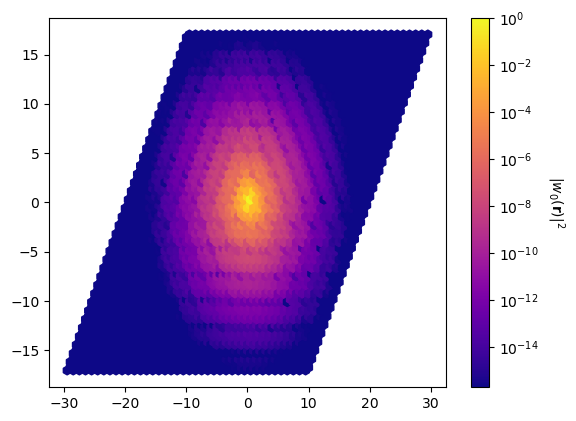

In [19]:
idx = 0
title = (
  "Haldane model \n"
  fr"$C = {chern: .1f}$, $\Delta = {delta}$, $t= {t: .2f}, t_2 = {t2: .2f}$"
  )

fig, ax = WF.plot_density(
    idx, show_lattice=False, lat_size=2, cbar=True, return_fig=True, interpolate=False
    )

# ax.set_xlim(-12, 12)
# ax.set_ylim(-12, 12)

Text(0, 0.5, 'Energy $E(\\mathbf{{k}})$ ')

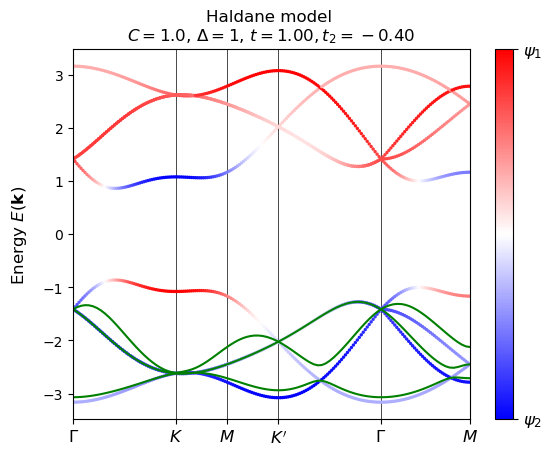

In [20]:
k_path = [[0, 0], [2/3, 1/3], [.5, .5], [1/3, 2/3], [0, 0], [.5, .5]]
k_label = (r'$\Gamma $',r'$K$', r'$M$', r'$K^\prime$', r'$\Gamma $', r'$M$')
(k_vec, k_dist, k_node) = model.k_path(k_path, 101, report=False)

interp_energies = WF.interp_energies(k_vec)

fig, ax = WF.energy_eigstates.plot_bands(
    k_path, nk=201, k_label=k_label, scat_size=2, red_lat_idx=high_E_sites
    )

# continuous bands
for n in range(interp_energies.shape[-1]):
    ax.plot(k_dist, interp_energies[:, n], c='green')

ax.set_title(title)
ax.set_ylabel(r"Energy $E(\mathbf{{k}})$ ")

In [15]:
k_path = [[0, 0], [2/3, 1/3], [.5, .5], [1/3, 2/3], [0, 0], [.5, .5]]
k_label = (r'$\Gamma $',r'$K$', r'$M$', r'$K^\prime$', r'$\Gamma $', r'$M$')
(k_vec, k_dist, k_node) = model.k_path(k_path, 201, report=False)

u_energy = WF.energy_eigstates.get_states()["Cell periodic"]
u_occ = u_energy[..., :n_occ, :]
u_tilde = WF.tilde_states.get_states()["Cell periodic"]

# deficient energies and states
interp_energies, interp_unk = WF.interp_energies(k_vec, ret_eigvecs=True)

# complementary energies and states
P, Q = WF.energy_eigstates.get_projector(return_Q=True) # full band projector
P_occ = np.einsum("...ni, ...nj -> ...ij", u_occ, u_occ.conj()) # occupied band projector
Q_occ = np.eye(P_occ.shape[-1]) - P_occ[..., :, :] # occ complement
P_tilde, Q_tilde = WF.tilde_states.get_projector(return_Q=True) # tilde space projectors
P_diff = P_occ - P_tilde # complement to tilde adding to P_occ

eigvals, eigvecs = np.linalg.eigh(P_diff) # states spanning complement
u_comp = eigvecs[..., :, -1] # take state with non-zero eigval
u_comp = u_comp[..., np.newaxis, :] # single state

interp_energies_comp, interp_unk_comp = WF.interp_energies(k_vec, u_tilde=u_comp, ret_eigvecs=True) # complement energies on k-path

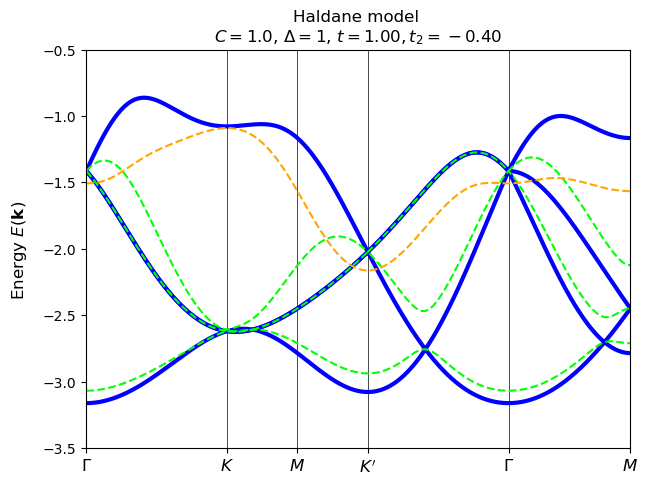

In [28]:
# actual bands
fig, ax = WF.energy_eigstates.plot_bands(
    k_path, nk=501, k_label=k_label, scat_size=4
    )

# fig, ax = plt.subplots()

### deficient bands
# wt = abs(interp_unk)**2
# col = np.sum([  wt[..., i] for i in high_E_sites], axis=0)
# for n in range(interp_energies.shape[-1]):
#     scat = ax.scatter(k_dist, interp_energies[:, n], c=col[:, n], cmap='plasma', marker='*', s=2, vmin=0, vmax=1, zorder=2)
# cbar = fig.colorbar(scat, ticks=[1,0])
# cbar.ax.set_yticklabels([r'$\psi_1$', r'$\psi_2$'], size=12)
# band_type = "def"

# continuous bands
for n in range(interp_energies.shape[-1]):
    ax.plot(k_dist, interp_energies[:, n], c='lime', ls='--', label='Deficient')

## complementary bands
# wt = abs(interp_unk_comp)**2
# col = np.sum([  wt[..., i] for i in high_E_sites], axis=0)
# for n in range(interp_energies_comp.shape[-1]):
#     scat = ax.scatter(k_dist, interp_energies_comp[:, n], c=col[:, n], cmap='plasma', marker='*', s=2, vmin=0, vmax=1, zorder=2)
# cbar = fig.colorbar(scat, ticks=[1,0])
# cbar.ax.set_yticklabels([r'$\psi_1$', r'$\psi_2$'], size=12)
# band_type = "comp"

# continuous bands
for n in range(interp_energies_comp.shape[-1]):
    ax.plot(k_dist, interp_energies_comp[:, n], c='orange', ls='--', label='Complement')

ax.set_title(title)
ax.set_ylabel(r"Energy $E(\mathbf{{k}})$ ")
ax.set_ylim(-3.5, -0.5)
# plt.legend()
plt.subplots_adjust(top=0.9, left=0.13, bottom=0.07, right=0.98)
# fig.set_size_inches()
# plt.savefig(f"images/interp_{band_type}_bands.png", dpi=700)
plt.savefig("images/interp_all_bands.png", dpi=700)